In [94]:
from pyspark.sql import functions as F
from _global_vars import *
import seaborn as sns
import numpy as np

In [95]:
# read in sdf
sdf = spark.read.parquet('../data/curated/yt2019_feature_eng.parquet')
#sdf.show(1, vertical=True, truncate=100)

**Note:** *a subsample is taken heterogeneously for visualisations due to the large size of the dataset*

In [96]:
# sub sample of (0.025%) approx. 850k records
print(f"Before subsampling size: {sdf.count()}")
sdf_sub = sdf.sample(fraction=0.01, seed=0) #TODO Check this
print(f"After subsampling size: {sdf_sub.count()}")

Before subsampling size: 7692971
After subsampling size: 76443


In [97]:
# convert to pandas dataframe
df_sub = sdf_sub.toPandas()

---
#### Univariate Analysis of Features
---

**Passenger count**

In [98]:
# numerically
sdf.groupBy("passenger_count").count().sort("passenger_count").show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|           null|  28665|
|            0.0| 117334|
|            1.0|5453944|
|            2.0|1113367|
|            3.0| 314545|
|            4.0| 140684|
|            5.0| 323663|
|            6.0| 200712|
|            7.0|     19|
|            8.0|     29|
|            9.0|      9|
+---------------+-------+



<AxesSubplot:xlabel='passenger_count', ylabel='count'>

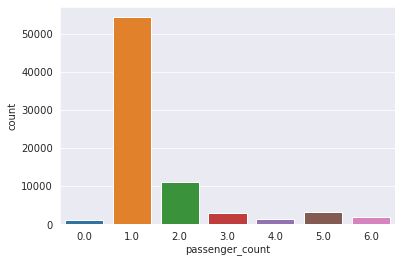

In [99]:
# visually
sns.countplot(x=df_sub['passenger_count'])

In [100]:
df_sub[df_sub['passenger_count'] > 5]

,hour_of_day_of_year,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,...,PU_dayofmonth,DO_dayofmonth,PU_month,DO_month,trip_time_minutes,trip_speed_mph,fare_per_minute,tmpf,dwpf,relh
91,2019-01-01 00:00:00,2,2019-01-01 00:42:31,2019-01-01 00:49:16,6.0,1.39,1.0,142,238,2,...,1,1,1,1,6.750000,12.355556,1.037037,44.1,42.1,92.620000
119,2019-01-01 00:00:00,2,2019-01-01 00:22:13,2019-01-01 00:26:23,6.0,0.73,1.0,263,140,1,...,1,1,1,1,4.166667,10.512000,1.200000,44.1,42.1,92.620000
192,2019-01-01 01:00:00,2,2019-01-01 01:03:15,2019-01-01 01:25:20,6.0,3.70,1.0,137,143,1,...,1,1,1,1,22.083333,10.052830,0.747170,44.7,43.0,93.726667
273,2019-01-01 01:00:00,2,2019-01-01 01:27:41,2019-01-01 01:41:09,6.0,2.87,1.0,43,168,1,...,1,1,1,1,13.466667,12.787129,0.853960,44.7,43.0,93.726667
283,2019-01-01 01:00:00,2,2019-01-01 01:43:48,2019-01-01 01:53:25,6.0,1.88,1.0,90,144,1,...,1,1,1,1,9.616667,11.729636,0.883882,44.7,43.0,93.726667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75831,2019-01-31 21:00:00,2,2019-01-31 21:14:30,2019-01-31 21:33:06,6.0,4.81,1.0,87,50,1,...,31,31,1,1,18.600000,15.516129,0.940860,15.1,-9.0,32.800000
75834,2019-01-31 21:00:00,2,2019-01-31 21:28:19,2019-01-31 21:37:40,6.0,1.45,1.0,107,211,1,...,31,31,1,1,9.350000,9.304813,0.855615,15.1,-9.0,32.800000
76032,2019-01-31 22:00:00,2,2019-01-31 22:24:59,2019-01-31 22:42:58,6.0,2.66,1.0,230,114,2,...,31,31,1,1,17.983333,8.874884,0.722892,15.1,-9.0,32.800000
76117,2019-01-31 23:00:00,2,2019-01-31 23:02:49,2019-01-31 23:06:07,6.0,0.75,1.0,249,90,1,...,31,31,1,1,3.300000,13.636364,1.363636,14.0,-9.0,34.410000


In [101]:
# take a peak at the extreme values
try:
    p_count_out_of_range = df_sub[df_sub['passenger_count'] > 6]
    sns.countplot(x=p_count_out_of_range['passenger_count'])
except ValueError:
    pass

Findings:
* Passenger count has values up to 9.
* Should be limited between 1-6. According to TLC guidelines
* Higher values for 9 passengers than for that of 8
* Suggesting the taxi driver might occasionally just enter the highest number?

Upshot:
* Restrict range of passenger_count (1:6) [drop other records]

**Trip distance**

In [102]:
# peak at negative tail values
sdf.groupBy("trip_distance").count().sort("trip_distance").show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|          0.0|55014|
|         0.01| 4035|
|         0.02| 2651|
|         0.03| 2082|
|         0.04| 1626|
|         0.05| 1417|
|         0.06| 1206|
|         0.07| 1082|
|         0.08| 1006|
|         0.09|  904|
|          0.1| 7747|
|         0.11|  875|
|         0.12|  947|
|         0.13|  904|
|         0.14|  972|
|         0.15| 1143|
|         0.16| 1164|
|         0.17| 1232|
|         0.18| 1483|
|         0.19| 1425|
+-------------+-----+
only showing top 20 rows



In [103]:
# peak at positive tail values
sdf.groupBy("trip_distance").count().sort(F.desc("trip_distance")).show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|        831.8|    1|
|        700.7|    1|
|       214.01|    1|
|       211.36|    1|
|       201.27|    1|
|       160.52|    1|
|        144.2|    1|
|       143.63|    1|
|       142.88|    1|
|        132.8|    1|
|       131.47|    1|
|       128.73|    1|
|       128.26|    1|
|       123.42|    1|
|        121.8|    1|
|        119.8|    1|
|       115.85|    1|
|       113.71|    1|
|       113.58|    1|
|       112.82|    1|
+-------------+-----+
only showing top 20 rows



In [104]:
# some serious distances being covered
sdf.sort(F.desc("trip_distance")).limit(5)

hour_of_day_of_year,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,congestion_surcharge,PU_datetime,DO_datetime,PU_hourofday,DO_hourofday,PU_dayofweek,DO_dayofweek,PU_dayofmonth,DO_dayofmonth,PU_month,DO_month,trip_time_minutes,trip_speed_mph,fare_per_minute,tmpf,dwpf,relh
2019-01-25 21:00:00,1,2019-01-25 21:56:39,2019-01-25 22:06:08,1.0,831.8,1,140,239,1,8.5,1.96,0.0,2019-01-25,2019-01-25,21,22,6,25,25,25,1,1,9.483333333333333,5262.706502636204,0.8963093145869948,35.1,6.1,29.12
2019-01-18 16:00:00,1,2019-01-18 16:32:24,2019-01-18 16:39:20,1.0,700.7,1,236,262,1,6.0,1.2,null,2019-01-18,2019-01-18,16,16,6,18,18,18,1,1,6.933333333333334,6063.75,0.8653846153846153,36.666666666666664,32.0,83.03000000000002
2019-01-28 17:00:00,2,2019-01-28 17:24:11,2019-01-29 04:37:16,5.0,214.01,1,265,265,2,760.0,0.0,0.0,2019-01-28,2019-01-29,17,4,2,29,28,29,1,1,673.0833333333334,19.077281168750773,1.129132103503776,28.0,6.1,38.79
2019-01-20 12:00:00,2,2019-01-20 12:22:24,2019-01-20 17:05:36,2.0,211.36,5,132,265,2,50.0,0.0,null,2019-01-20,2019-01-20,12,17,1,20,20,20,1,1,283.2,44.779661016949156,0.1765536723163842,37.0,36.0,96.13
2019-01-21 10:00:00,2,2019-01-21 10:13:05,2019-01-21 13:28:01,1.0,201.27,5,208,265,1,150.0,0.0,0.0,2019-01-21,2019-01-21,10,13,2,21,21,21,1,1,194.93333333333334,61.950410396716826,0.7694938440492476,7.0,-8.0,49.38


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

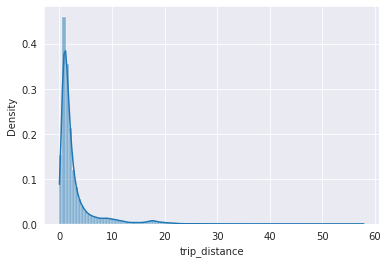

In [105]:
sns.histplot(x=df_sub['trip_distance'], bins=100, kde=True, stat='density')

/home/noahs/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

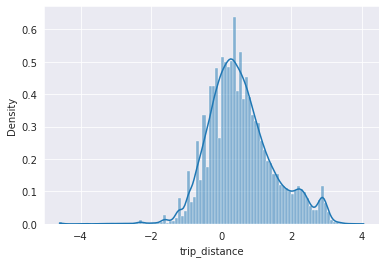

In [106]:
# perform log transformation to help visualise
sns.histplot(x=np.log(df_sub['trip_distance']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_distance'>

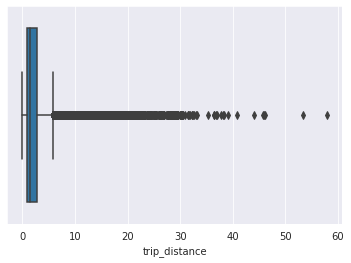

In [107]:
sns.boxplot(x=df_sub['trip_distance'])

Findings:
* Looks extremely right skewed
* Divide by zero error thrown => we have non strictly positive trip distances
* Extremely long trip distances => -33,000 kms! not representative in sample tho
* Most positive distances seem reasonable, worthy of further inspection
* Contains negative distances
* Contains extremely large distances

Upshot:
* Log transformation might be useful when intending to model
* Restrict to entries with: 0 < trip distance < 312km

>312km is chosen as it bounds all relevant taxi zones

**Fare amount**

In [108]:
# inspect positive tail
sdf.groupBy("fare_amount").count().sort(F.desc("fare_amount")).show()

+-----------+-----+
|fare_amount|count|
+-----------+-----+
|  623259.86|    1|
|  355676.98|    1|
|    36090.3|    1|
|   34674.65|    1|
|   33023.53|    1|
|   31107.91|    1|
|   30444.52|    1|
|   30130.71|    1|
|   25628.96|    1|
|   25356.38|    1|
|   24249.43|    1|
|   20765.39|    1|
|   19863.26|    1|
|   19194.52|    1|
|   18477.08|    1|
|   17242.81|    1|
|   16032.47|    2|
|     8000.3|    1|
|    6666.65|    1|
|     3004.0|    1|
+-----------+-----+
only showing top 20 rows



In [109]:
# inspect negative tail
sdf.groupBy("fare_amount").count().sort("fare_amount").show()

+-----------+-----+
|fare_amount|count|
+-----------+-----+
|     -362.0|    1|
|     -320.0|    1|
|     -300.0|    2|
|     -284.0|    1|
|     -252.0|    1|
|    -250.01|    1|
|     -243.0|    1|
|     -230.0|    2|
|     -224.0|    1|
|     -190.0|    1|
|     -183.0|    1|
|     -170.0|    1|
|     -165.0|    1|
|     -160.0|    1|
|     -156.0|    1|
|     -150.0|    3|
|     -148.0|    1|
|    -142.06|    1|
|     -130.0|    1|
|     -120.0|    1|
+-----------+-----+
only showing top 20 rows



<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

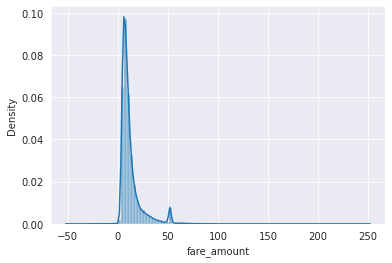

In [110]:
sns.histplot(x=df_sub['fare_amount'], bins=100, kde=True, stat='density')

/home/noahs/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/noahs/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

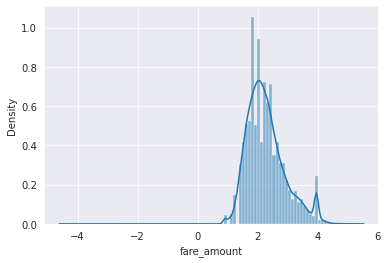

In [111]:
# perform log transformation to help visualise right skew
sns.histplot(x=np.log(df_sub['fare_amount']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='fare_amount'>

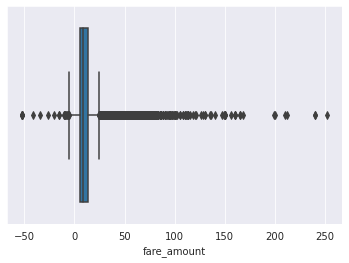

In [112]:
sns.boxplot(x=df_sub['fare_amount'])

In [113]:
# inspect fares above 2.50 (USD)
capped_fare_amnt = df_sub[df_sub['fare_amount'] > 2.5]

<AxesSubplot:xlabel='fare_amount'>

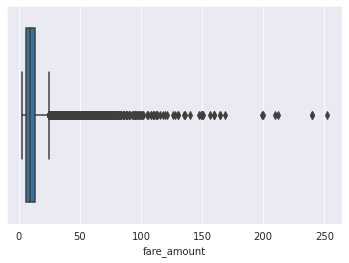

In [114]:
sns.boxplot(x=capped_fare_amnt['fare_amount'])

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

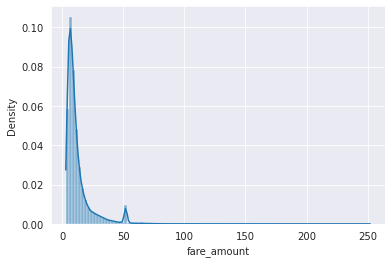

In [115]:
sns.histplot(x=capped_fare_amnt['fare_amount'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

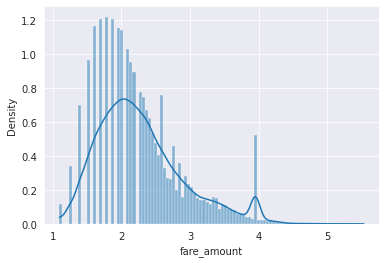

In [116]:
sns.histplot(x=np.log(capped_fare_amnt['fare_amount']), bins=100, kde=True, stat='density')

Findings:
* Fare amount contains zero values
* Right skewed
* Extremely high fare values in full dataset
* Extremely negative fare values in full dataset
* Fare values shows banding when looking at the subsample
* Peaks at fare amounts of around log(4): could be airport or hotspot etc

Upshot:
* Take log
* Restrict values between 1.5*IQR
* Fares capped at $500

**Trip speed (mph)**

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

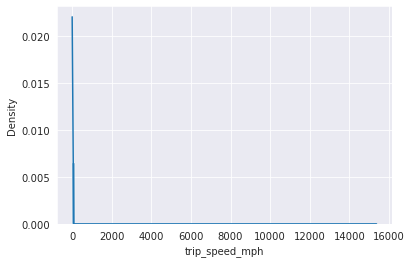

In [117]:
sns.histplot(x=df_sub['trip_speed_mph'], bins=100, kde=True, stat='density')

/home/noahs/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

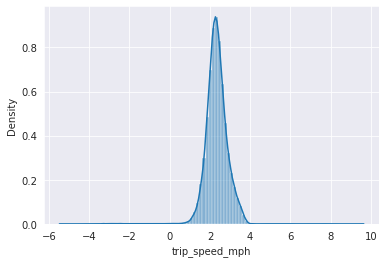

In [118]:
sns.histplot(x=np.log(df_sub['trip_speed_mph']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_speed_mph'>

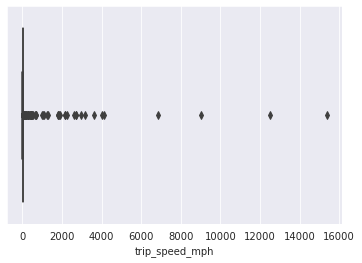

In [119]:
sns.boxplot(x=df_sub['trip_speed_mph'])

In [120]:
# investigate distribution with restrictions; speeds between 1 and 65 mph
capped_speed = df_sub[(df_sub['trip_speed_mph'] <= 65) & (df_sub['trip_speed_mph'] > 1)]

<AxesSubplot:xlabel='trip_speed_mph'>

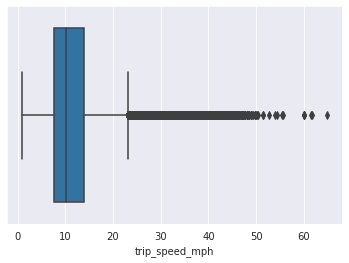

In [121]:
sns.boxplot(x=capped_speed['trip_speed_mph'])

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

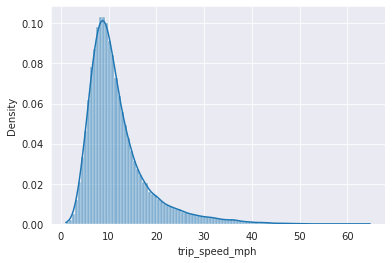

In [122]:
# right skewed again
sns.histplot(x=capped_speed['trip_speed_mph'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

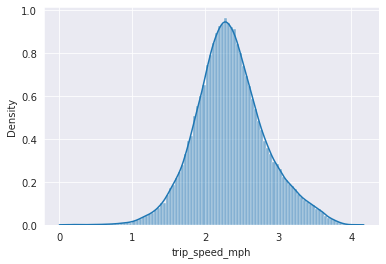

In [123]:
# doesn't that look nice?
sns.histplot(x=np.log(capped_speed['trip_speed_mph']), bins=100, kde=True, stat='density')

Findings:
* Extreme speeds.
* NYC speed limit is 65 mph at the most on the highways, most of it should be less than that if it is taking place in NYC
* Trips that had a speed of less than 1 mph?

Implements:
* remove trips with average speed over 65 mph
* remove trips less than 1 mph


**Trip Duration** (expected to be highly correlated with trip speed)

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

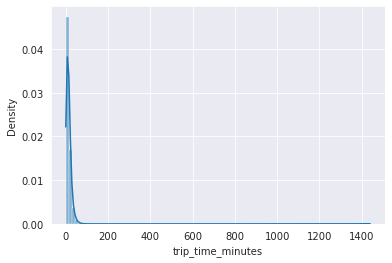

In [124]:
sns.histplot(x=df_sub['trip_time_minutes'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_time_minutes'>

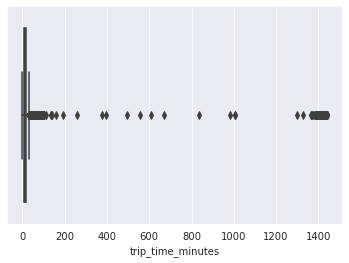

In [125]:
sns.boxplot(x=df_sub['trip_time_minutes'])

/home/noahs/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

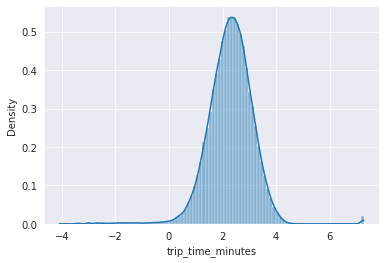

In [126]:
sns.histplot(x=np.log(df_sub['trip_time_minutes']), bins=100, kde=True, stat='density')

In [127]:
# investigate distribution with restrictions;
# -> trip times less than 8 hours and longer than 2 minutes
capped_time = df_sub[(df_sub['trip_time_minutes'] <= 480) & (df_sub['trip_time_minutes'] > 2)]

<AxesSubplot:xlabel='trip_time_minutes'>

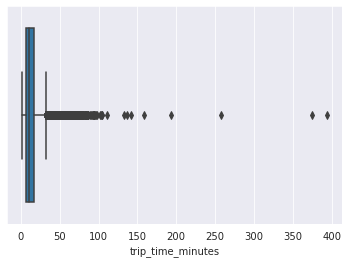

In [128]:
sns.boxplot(x=capped_time['trip_time_minutes'])

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

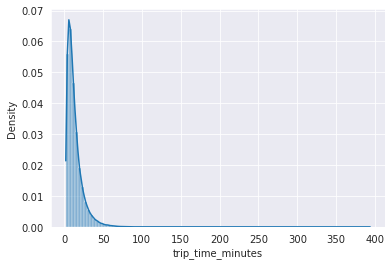

In [129]:
# right skewed again, again
sns.histplot(x=capped_time['trip_time_minutes'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

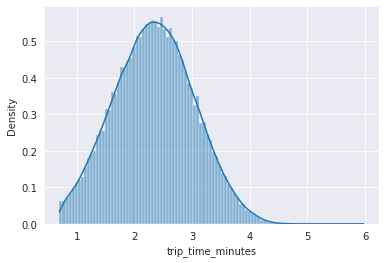

In [130]:
# much more gaussian
sns.histplot(x=np.log(capped_time['trip_time_minutes']), bins=100, kde=True, stat='density')

Findings:
* Extremely long trip times up to 1400 minutes (just in the sample)

Upshot:
* Limit trip times to under 8 hours (480 minutes) (a whole shift, which would be a big ask for a taxi driver)
* Trips with a time of less than 2 minutes should be excluded as they are
    * Not very realistic
    * Or the passenger may have cancelled

---
### Date/Time Analysis
---

**Distribution of trips across time**
> Months of year

In [131]:
month_counts = sdf.groupBy("PU_month").count()
month_counts_df = month_counts.toPandas()

   PU_month    count
0         1  7692877
1         6        2
2         3        5
3         5        1
4         9        1
5         4        6
6         8        1
7         7        6
8         2       72


<AxesSubplot:xlabel='PU_month', ylabel='count'>

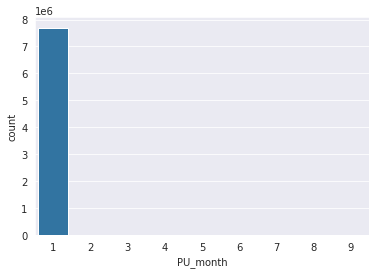

In [132]:
# numerically
print(month_counts_df)
# visually
sns.barplot(x=month_counts_df['PU_month'], y=month_counts_df['count'])

> Weeks of the year

In [133]:
PU_day_of_week_df = sdf.groupBy("PU_dayofweek").count().toPandas()

   PU_dayofweek    count
0             1   859896
1             6  1087213
2             3  1209084
3             5  1356992
4             4  1265230
5             7  1009983
6             2   904573


<AxesSubplot:xlabel='PU_dayofweek', ylabel='count'>

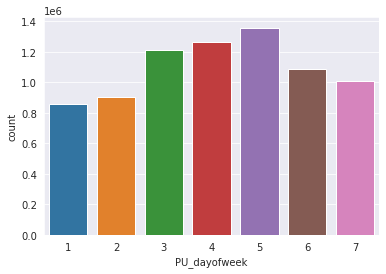

In [134]:
# numerically
print(PU_day_of_week_df)
# visually
sns.barplot(x=PU_day_of_week_df['PU_dayofweek'],
            y=PU_day_of_week_df['count'])

**Pickup Locations**

In [135]:
PU_LocationID_Counts = sdf.groupBy("PULocationID").count().toPandas()

     PULocationID   count
142            84       1
257           104       1
228           199       2
135           176       2
214           204       3
..            ...     ...
38            230  263990
136           162  277405
131           161  312790
30            236  323257
174           237  332743

[263 rows x 2 columns]


<AxesSubplot:xlabel='PULocationID', ylabel='count'>

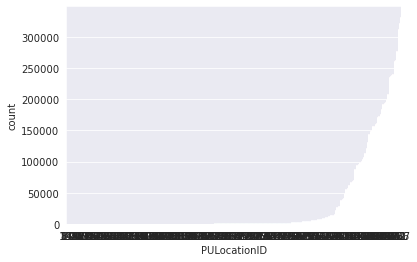

In [136]:
# Pickup day of week -> by count

print(PU_LocationID_Counts.sort_values('count'))
PULocationID_counts_sorted = PU_LocationID_Counts.sort_values('count')

sns.barplot(x=PULocationID_counts_sorted['PULocationID'], y=PULocationID_counts_sorted['count'], order=PULocationID_counts_sorted['PULocationID'])

In [138]:
# peek at distribution of the highest frequency pickup locations
PULocationID_counts_top = PU_LocationID_Counts[PU_LocationID_Counts['count'] > 2000000]
try:
    sns.barplot(x=PULocationID_counts_top['PULocationID'], y=PULocationID_counts_top['count'])
except ValueError:
    # null df
    pass

**Pick Up Times**

In [139]:
PU_hourofday_counts = sdf.groupBy("PU_hourofday").count().toPandas()

<AxesSubplot:xlabel='PU_hourofday', ylabel='count'>

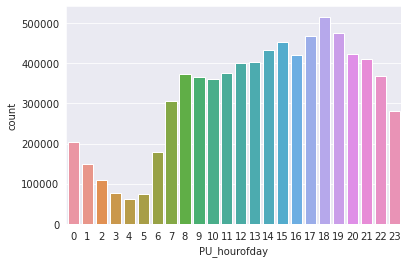

In [140]:
# Note; the timezones are off
sns.barplot(x=PU_hourofday_counts['PU_hourofday'], y=PU_hourofday_counts['count'])

**Congestion Surcharge**

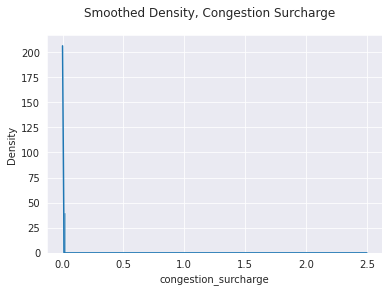

In [141]:
#df_sub['congestion_surcharge']
con_hist = sns.histplot(x=df_sub['congestion_surcharge'], bins=100, kde=True, stat='density')
fig = con_hist.get_figure()
fig.suptitle("Smoothed Density, Congestion Surcharge")
fig.savefig('../plots/congestion_surcharge_density.png')

<AxesSubplot:xlabel='congestion_surcharge'>

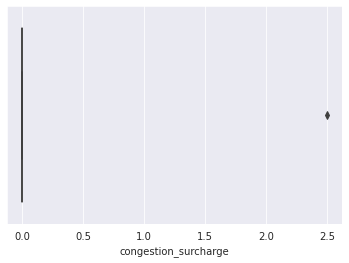

In [142]:
sns.boxplot(x=df_sub['congestion_surcharge'])

In [143]:
df_sub['congestion_surcharge'].sort_values(ascending=False)

72343    2.5
48157    0.0
66873    0.0
66884    0.0
66883    0.0
        ... 
76438    NaN
76439    NaN
76440    NaN
76441    NaN
76442    NaN
Name: congestion_surcharge, Length: 76443, dtype: float64

Findings:
* Congestion surcharge contains negative values
* Doesnt appear to go above $3
* has two peaks? for whatever reason

Upshot:
* Congestion surcharge capped at 10 usd -> any records beyond this can go away
* Range [0:10]

---
#### Categorical Variable Analysis #
---

**VendorID**

+--------+-------+
|VendorID|  count|
+--------+-------+
|       1|2937568|
|       2|4678513|
|       4|  76791|
|       5|     99|
+--------+-------+



<AxesSubplot:xlabel='VendorID', ylabel='count'>

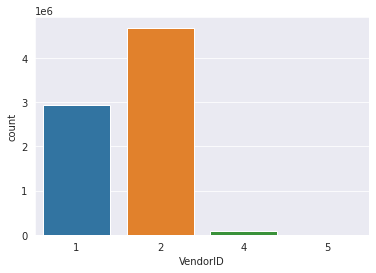

In [144]:
# numerically
sdf.groupBy("VendorID").count().sort("VendorID").show()
# visually
vendorid_groups = sdf.groupBy("VendorID").count().sort("VendorID").toPandas()
sns.barplot(x=vendorid_groups['VendorID'], y=vendorid_groups['count'])

Visualisations not very useful due to large class imbalance
* Hence limit investigation to valid VendorID's

<AxesSubplot:xlabel='VendorID', ylabel='count'>

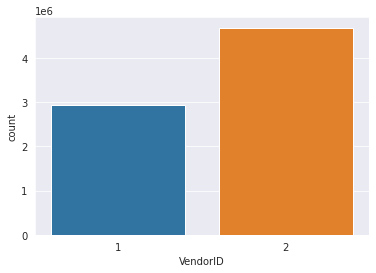

In [145]:
# limit vendorID
vendorid_groups_clean = vendorid_groups[(vendorid_groups['VendorID'] == 1) | (vendorid_groups['VendorID'] == 2)]
sns.barplot(x=vendorid_groups_clean['VendorID'], y=vendorid_groups_clean['count'])

Findings
* VendorID should be only 1,2
* Contains 4,5's
* VendorID 2 has a significant share of trips compared to VendorID 1

Upshot:
* Remove rows with incorrect VendorID -> limit range to (1:2)

**RatecodeID**

In [146]:
ratecodeid_ = sdf.groupBy("RatecodeID").count().sort("RatecodeID").toPandas()
ratecodeid_

,RatecodeID,count
0,NaN,28665
1,1.0,7426901
2,2.0,165894
3,3.0,11797
4,4.0,4889
5,5.0,54528
6,6.0,45
7,99.0,252


<AxesSubplot:xlabel='RatecodeID', ylabel='count'>

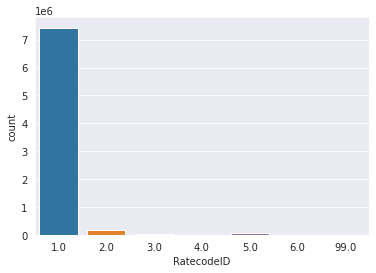

In [147]:
sns.barplot(x=ratecodeid_['RatecodeID'], y=ratecodeid_['count'])

Findings:
* Ratecode should be between 1-6 according to NYC TLC guidelines
* Contains 99? Could be due to driver just inputting 99 when they encounter an issue

Upshot:
* Limit ratecodeID entries between [1,6]
* Maybe only use standard rate ratecodes?

**Payment Type**

In [148]:
payment_type = sdf.groupBy("payment_type").count().sort("payment_type").toPandas()
payment_type

,payment_type,count
0,0,28665
1,1,5484030
2,2,2135970
3,3,33149
4,4,11157


Findings:
* According to yellow taxi data dictionary: we are only interested in Credit Card (1) and Cash (2)

Upshot:
* Remove payment types != 1,2

In [149]:
spark.sql("CLEAR CACHE")
spark.stop()